<img src="files/night_sky_eye_small.jpg">
# Image_comparison Script

Jessica Metzger (UChicago) and Jim Annis (Fermilab) 2018


To run this notebook:
  * the geckodriver executable needs to be in the environmental variable $PATH
      **export PATH=$PATH:/data/des30.a/data/annis/dae-haven/py-lib/lib/python2.7/site-packages/geckodriver/
  * you'll need to run 
       ** conda activate des18a"
  * and set the python path:
       ** PYTHONPATH=$PYTHONPATH:/data/des30.a/data/annis/dae-haven/py-lib/lib/python;export PYTHONPATH;
       ** PYTHONPATH=$PYTHONPATH:/data/des30.a/data/annis/dae-haven/py-lib/lib/python2.7/site-packages;export PYTHONPATH;
       
 *(to run a notebook remotely, see 
 http://home.fnal.gov/~kadrlica/fnalstart.html
 
 ## How this should work
 
 * Given a search image:
 * Select from the 200mpc catalog the likely galaxies in the image as a list of ra,dec's
 * If in panstarrs area, run the current script for each ra, dec
     ** teach this code to know where the search image is
 * If we want to see DECam template images
 ** find the DECam images that overlap (from the diffimage pipeline or from Alex)
 *** teach the code to accept a list of template DECam images
 ** teach the code to look there for those images and deal gracefully with no matches
     *** where is there? ideally all the DECam images are on disk at Fermilab. There.


In [1]:
from astropy import wcs
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import time,os
import glob
import fitsio

#import ps1
import support

In [2]:
# 
# given a ra,dec of a search image, 
# return the list of gals and thumbs
#
def get_list_of_gals_and_cutouts(ra,dec, path_to_cutouts="/data/des70.a/data/annis/s190510/", verbose=False) :
    file = glob.glob(path_to_cutouts + "matched*csv")
    dc_ra, dc_dec = np.genfromtxt(file[0],unpack=True,usecols=(0,1),delimiter=",", skip_header=1)
    thumb = np.genfromtxt(file[0],unpack=True,usecols=(3),delimiter=",",skip_header=1,dtype="str")
    
    distance = np.sqrt( ((ra-dc_ra)*np.cos(dc_dec*2*np.pi/360.))**2 + (dec-dc_dec)**2)
    #distance = support.gc_separation(ra, dec, dc_ra, dc_dec)
    ix = distance < 1.2
    gals_ra, gals_dec = dc_ra[ix], dc_dec[ix]
    for i in range(gals_ra.size):
        if verbose:
            print "{} {:10.5f} {:10.5f} \t {}".format(i, gals_ra[i], gals_dec[i], thumb[ix][i])
    return gals_ra, gals_dec, thumb[ix]
    
# 
# given a thumb name, return image
# return the list of gals and thumbs
#
def get_des_cutout_image(thumb_name, filter="g", path_to_cutouts="/data/des70.a/data/annis/s190510/") :
    fits = fitsio.FITS(path_to_cutouts+thumb_name+"_{}.fits".format(filter))
    img = fits[0].read()
    return img

In [3]:
%matplotlib inline
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
import healpy as hp
import os
import numpy as np
import matplotlib.pyplot as plt
from math import fabs
import numpy as np
from astropy.wcs import WCS

def raw_cutout(infilename, ra,dec,stampSize, verbose=True): #Stampsize is half width
    
    ptsInside2Rp = []
    print("Opening file: " + infilename)
    hdulist = fits.open(infilename)
    
    found = False
    for ccd in range(1,63):
        if verbose: print ccd,
        header = fits.open(infilename)[ccd].header #pyfits.getheader(infilename, 0)
        #print header
        data = fits.open(infilename)[ccd].data
        try:
            ylen, xlen = data.shape[0], data.shape[1]
        except:
            if verbose: print "no data"
            continue
    
        #Find pixel at the candidate ra dec
        w = WCS(header=header) 
       
        px, py = w.all_world2pix(ra, dec, 1)
        objcoord = [px, py]
        if np.isnan(px) or np.isnan(py):
            if verbose: print "isnan"
            continue
        corners = w.calc_footprint()
        if (px < -1024 or px > 1024): continue
        if (py < -2048 or py > 2048): continue 
        print corners
        print ra,dec
        found = True
        if found: 
            print objcoord
            break
        
    if verbose: 
        if not found: 
            print "Not Found"
            return -1

    X = int(px)
    Y = int(py)
    
    #cutting image:
    
    sizy = np.min(np.array([stampSize, fabs(ylen-stampSize)]))
    sizx = np.min(np.array([stampSize, fabs(xlen-stampSize)]))  
    siz = int(np.min(np.array([sizy,sizx])))
    if verbose: print "cutout:",siz,px,py

    data = data[Y-siz:Y+siz+1,X-siz:X+siz+1]  

    return data

def cutout(infilename,ra,dec,stampSize): #Stampsize is half width
    
    ptsInside2Rp = []
    print("Opening file: " + infilename)
    hdulist = fits.open(infilename)
    header = fits.open(infilename)[1].header #pyfits.getheader(infilename, 0)
    data = fits.open(infilename)[1].data
    ylen, xlen = data.shape[0], data.shape[1]
    
    #Find pixel at the candidate ra dec
    w = WCS(header=header) 
    px, py = w.all_world2pix(ra, dec, 1)
    objcoord = [px, py]
   

    X = int(px)
    Y = int(py)
    
    #cutting image:
    
    sizy = np.min(np.array([stampSize, fabs(ylen-stampSize)]))
    sizx = np.min(np.array([stampSize, fabs(xlen-stampSize)]))  
    siz = int(np.min(np.array([sizy,sizx])))
    print "cutout:",siz,px,py

    data = data[Y-siz:Y+siz+1,X-siz:X+siz+1]  

    return data

def find_BLISS_image(cand_ra,cand_dec,stampSize, filter):
    
    bands = ['g','r','i','z']
    cat_path = '/data/des81.a/data/luidhy/BLISS_allsky_try1/hpx/' 
    exp_path1 = '/data/des50.b/data/BLISS/'
    exp_path2 = '/data/des60.b/data/BLISS/'
    exp_path3 = '/data/des61.b/data/BLISS/'
    cat_nside = 32

    hpix = hp.ang2pix(cat_nside, cand_ra, cand_dec,lonlat=True)

    for band in bands:
        if band != filter : continue
        if hpix<10000:
            cat_file = cat_path+band+"/hpx_"+band+"_0"+str(hpix)+".fits"
        else:
            cat_file = cat_path+band+"/hpx_"+band+"_"+str(hpix)+".fits"
        if not os.path.isfile(cat_file):
            print "There is no source catalog in ", band
            exp_file = 0
            return ""
        else:
            h=fits.open(cat_file)[1].data
            print "Exposure available in ",band
            c1 = SkyCoord(cand_ra*u.deg, cand_dec*u.deg, frame='fk5')
            cat = SkyCoord(h['RA']*u.deg, h['DEC']*u.deg, frame='fk5')
            idx, d2d, d3d = c1.match_to_catalog_sky(cat)
            print "Closest object is at distance", d2d
            print "(RA,DEC)=",h['RA'][idx], h['DEC'][idx]
            print "Filter, mag, magerr", band, h['MAG_AUTO'][idx], h['MAGERR_AUTO'][idx]
            expnum = h['EXPNUM'][idx]
            ccdnum = h['CCDNUM'][idx]
            exp_fold = str(expnum)[:-2]+"00/"
            if (ccdnum<10): 
                ccdnum_str = "0"+str(ccdnum)
            else: 
                ccdnum_str = str(ccdnum)

            #Now open image

            exp_file1 = exp_path1+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"
            exp_file2 = exp_path2+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"
            exp_file3 = exp_path3+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"

            if os.path.isfile(exp_file1):
                exp_file = exp_file1
            elif os.path.isfile(exp_file2):
                exp_file = exp_file2
            elif os.path.isfile(exp_file3):
                exp_file = exp_file3
            else:
                print "Error: no exposure found in any path"
                exp_file = 0      

            #If image was found, make a cutout
            if (exp_file!=0):
                outfile = './cutouts/'+str(int(cand_ra))+str(int(cand_dec))+band+'.fits'
                img = cutout(exp_file,cand_ra,cand_dec,stampSize) #cand_ra,cand_dec
                img = np.rot90(img)
                img = np.fliplr(img)
      
            return img
    
def find_search_image(image_name, cand_ra,cand_dec,stampSize, dir="/data/des51.b/data/DTS/src/20190510/"):
    exp_file = dir+image_name
    img = raw_cutout(exp_file,cand_ra,cand_dec,stampSize) #cand_ra,cand_dec
    try:
        if img == -1: return -1
    except:
        img = np.rot90(img)
        img = np.fliplr(img)
      
    return img



In [64]:
%matplotlib inline
from astropy.wcs import WCS
from astropy.io import fits
import healpy as hp
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

def work_image(expid, image_ra,image_dec, filter="g",
               dir="/data/des51.b/data/DTS/src/20190510/", 
               do_bliss=False, do_cutout=True, verbose=True): #Stampsize is half width
    infilename = dir + "DECam_00{}.fits.fz".format(expid)

    print("Opening file: " + infilename)
    hdulist = fits.open(infilename)
    
    gra,gdec,thumbs = get_list_of_gals_and_cutouts(image_ra, image_dec)
    match_cutout = 15
    go_big = 25
    #match_cutout = 15
    if do_cutout: stampSize = match_cutout/0.27
    if do_bliss:   stampSize = go_big/0.27

    count = 0
    for ccd in range(1,63):
        if verbose: print ccd,
        header = fits.open(infilename)[ccd].header #pyfits.getheader(infilename, 0)
        #print header
        fixed_data = fits.open(infilename)[ccd].data
        try:
            ylen, xlen = fixed_data.shape[0], fixed_data.shape[1]
        except:
            if verbose: print "no data"
            continue
    
        #Find pixel at the candidate ra dec
        w = WCS(header=header) 
        for i in range(0,gra.size) :
            found = False
            px, py = w.all_world2pix(gra[i], gdec[i], 1)
            objcoord = [px, py]
            if np.isnan(px) or np.isnan(py):
                if verbose: print "isnan"
                continue
            corners = w.calc_footprint()
            #if (px < 0 or px > 2048): continue
            #if (py < 0 or py > 4096): continue 

            ccd_ra_min = corners[:,0].min()
            ccd_ra_max = corners[:,0].max()
            ccd_dec_min = corners[:,1].min()
            ccd_dec_max = corners[:,1].max()
            #print ccd_ra_min, gra[i],ccd_ra_max
            #print ccd_dec_min, gdec[i], ccd_dec_max
            if ((gra[i] < ccd_ra_min) or (gra[i] > ccd_ra_max)) :  continue
            if ((gdec[i] < ccd_dec_min) or (gdec[i] > ccd_dec_max)) :  continue
    
            #cutting image:
            X = int(px)
            Y = int(py+80)
            sizy = np.min(np.array([stampSize, fabs(ylen-stampSize)]))
            sizx = np.min(np.array([stampSize, fabs(xlen-stampSize)]))  
            siz = int(np.min(np.array([sizy,sizx])))
            print "cutout:",siz, np.int(sizx), np.int(sizy), "x,y len",xlen, ylen
            if X-siz < 0: 
                X=X- (X-siz)


            data = fixed_data[Y-siz:Y+siz+1,X-siz:X+siz+1] 
            data = np.rot90(data)
            data = np.fliplr(data)
            search = data


            fig,axs=plt.subplots(1,2,figsize=(15,5))
            axs=axs.ravel()
            fig.suptitle('RA = '+str(round(gra[i],6))+', DEC = '+str(round(gdec[i],6)))
    
                
            if do_cutout :
                template = get_des_cutout_image(thumbs[i], filter=filter)
                label = "DES coadd"
    
            if do_bliss:
                template = find_BLISS_image(gra[i],gdec[i],stampSize, filter)
                label = "Bliss single exposure"
                
            print "trying search + {}\n".format(label)
            try:
                axs[0].imshow(np.log10(template-np.amin(template)+1),origin='lower',cmap='gray')
                axs[0].set_title('template for gal {} {}'.format(i, label))
                axs[1].imshow(np.log10(search-np.amin(search)),origin='lower',cmap='gray')
                axs[1].set_title('search for gal {}'.format(i))
                plt.show()
                count += 1
            except:
                pass
    print "\n Did {} galaxies!\n".format(count)

In [8]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

Opening file: /data/des51.b/data/DTS/src/20190510/DECam_00856764.fits.fz
1 2 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.5933s]
(RA,DEC)= 87.90500449090855 -31.537098119618683
Filter, mag, magerr r 15.294369 0.0009248684
Opening file: /data/des61.b/data/BLISS/272500/272573/D00272573_r_59_r1p1_immask.fits.fz
cutout: 92 1398.5677420274533 2765.2732934797505
trying search + Bliss single exposure



/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in log10


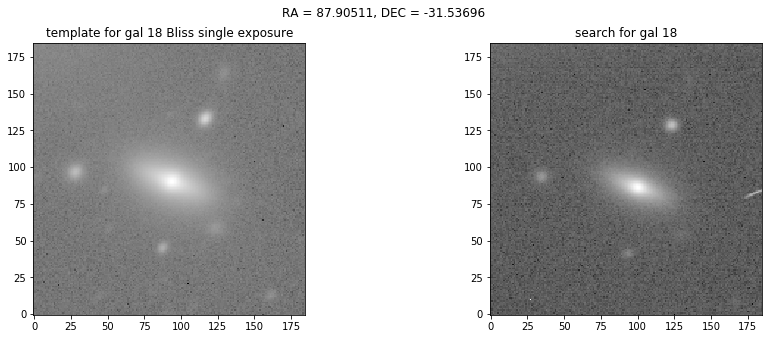

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m15.7457s]
(RA,DEC)= 87.91192148701433 -31.52182452586697
Filter, mag, magerr r 17.036217 0.0010594969
Opening file: /data/des61.b/data/BLISS/272500/272573/D00272573_r_59_r1p1_immask.fits.fz
cutout: 92 1209.084601668983 2903.132726482757
trying search + Bliss single exposure



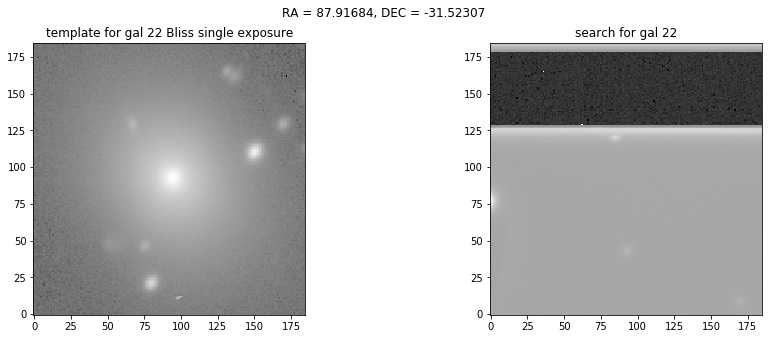

3 4 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m19.3352s]
(RA,DEC)= 87.23794533339064 -31.803614148687842
Filter, mag, magerr r 21.184422 0.055217385
Opening file: /data/des61.b/data/BLISS/704900/704921/D00704921_r_46_r1p1_immask.fits.fz
cutout: 92 416.7645507428133 3446.5750634161227
trying search + Bliss single exposure



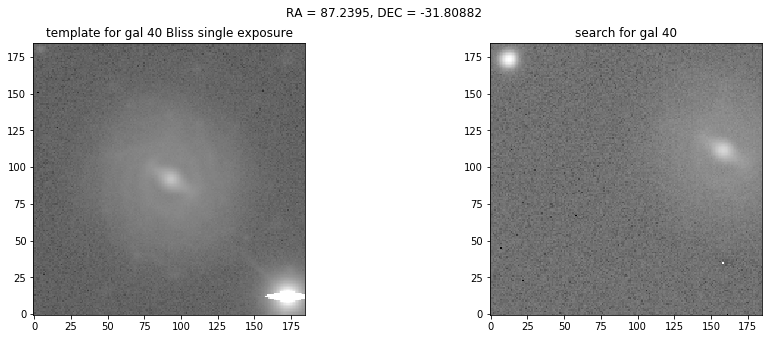

5 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m09.354s]
(RA,DEC)= 87.82330471899071 -31.823653430018332
Filter, mag, magerr r 16.71014 0.0015434385
Opening file: /data/des61.b/data/BLISS/718600/718652/D00718652_r_60_r1p1_immask.fits.fz
cutout: 92 310.22040140280114 3796.3751835196485
trying search + Bliss single exposure



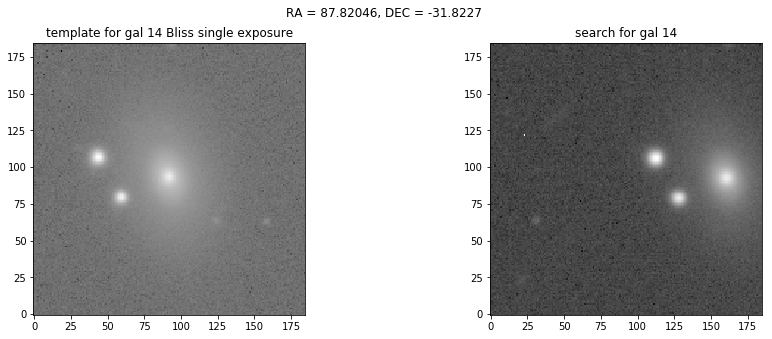

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.8443s]
(RA,DEC)= 87.81042968611564 -31.767021258158724
Filter, mag, magerr r 14.348934 0.0006790363
Opening file: /data/des61.b/data/BLISS/597600/597690/D00597690_r_09_r1p1_immask.fits.fz
cutout: 92 650.9258936462829 3795.9367609030915
trying search + Bliss single exposure



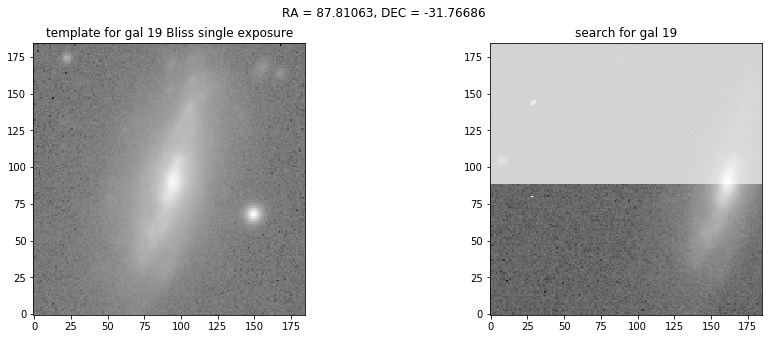

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m19.2878s]
(RA,DEC)= 87.72653013641231 -31.78374125793552
Filter, mag, magerr r 21.620098 0.06335167
Opening file: /data/des61.b/data/BLISS/704900/704921/D00704921_r_48_r1p1_immask.fits.fz
cutout: 92 136.9478515229912 593.4647126562296
trying search + Bliss single exposure



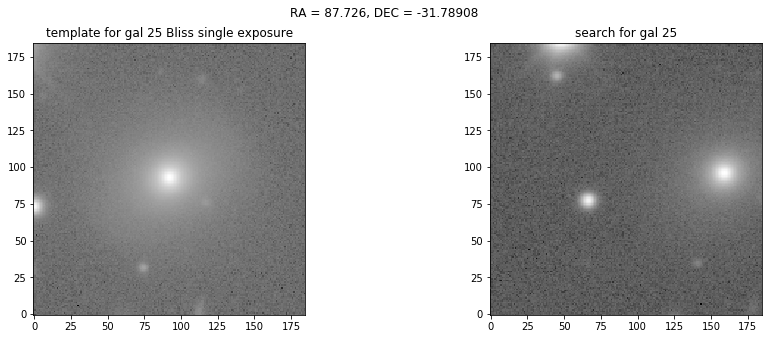

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.4872s]
(RA,DEC)= 87.70758446586285 -31.74068522967082
Filter, mag, magerr r 13.679556 0.0005202432
Opening file: /data/des61.b/data/BLISS/597600/597690/D00597690_r_09_r1p1_immask.fits.fz
cutout: 92 294.6660398966269 2598.256903857086
trying search + Bliss single exposure



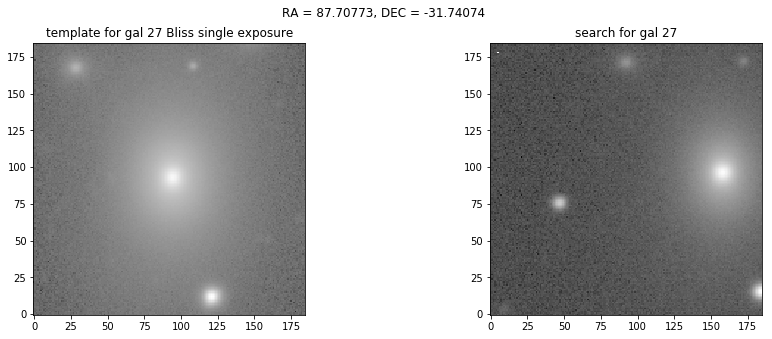

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m08.6303s]
(RA,DEC)= 87.68373958801315 -31.75957635398613
Filter, mag, magerr r 21.439487 0.06871758
Opening file: /data/des61.b/data/BLISS/718600/718652/D00718652_r_57_r1p1_immask.fits.fz
cutout: 92 1676.1265519810222 105.90826805544303
trying search + Bliss single exposure



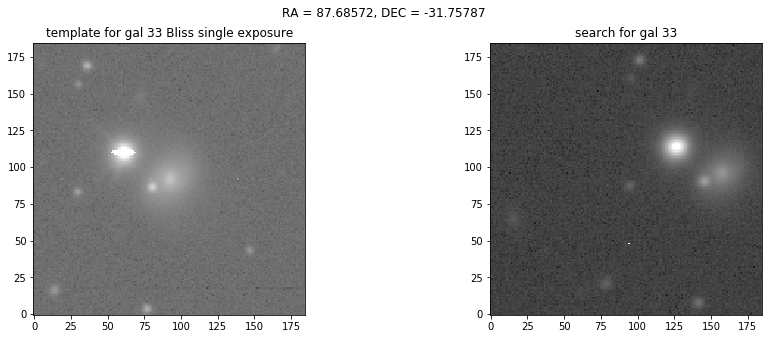

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.3799s]
(RA,DEC)= 87.65014532323566 -31.821386697022035
Filter, mag, magerr r 16.65017 0.0020342409
Opening file: /data/des61.b/data/BLISS/514200/514253/D00514253_r_44_r1p1_immask.fits.fz
cutout: 92 1302.2603811876506 3188.2351221887443
trying search + Bliss single exposure



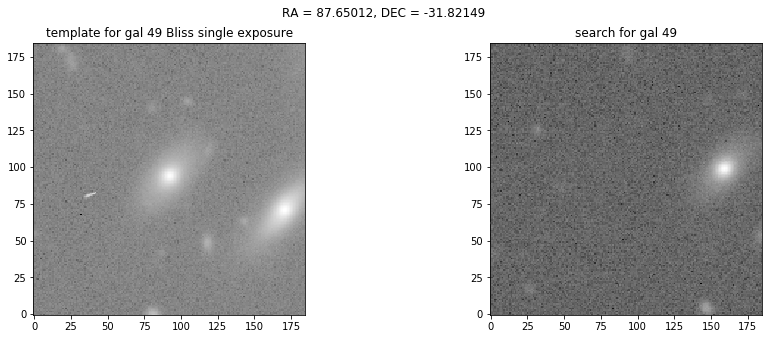

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m17.6519s]
(RA,DEC)= 87.63194182387493 -31.81762651921323
Filter, mag, magerr r 19.283758 0.008023014
Opening file: /data/des61.b/data/BLISS/704900/704921/D00704921_r_47_r1p1_immask.fits.fz
cutout: 92 484.52739163391016 3800.3523257940283
trying search + Bliss single exposure



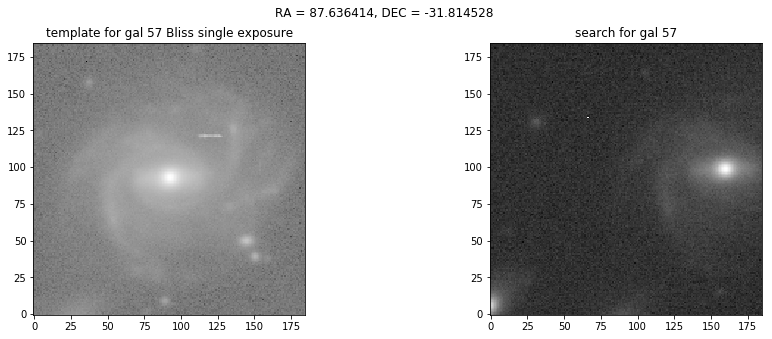

6 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.4186s]
(RA,DEC)= 87.99563232012893 -31.784106083438292
Filter, mag, magerr r 16.67934 0.0020303875
Opening file: /data/des61.b/data/BLISS/597600/597690/D00597690_r_10_r1p1_immask.fits.fz
cutout: 92 885.503728580934 1696.5963244400123
trying search + Bliss single exposure



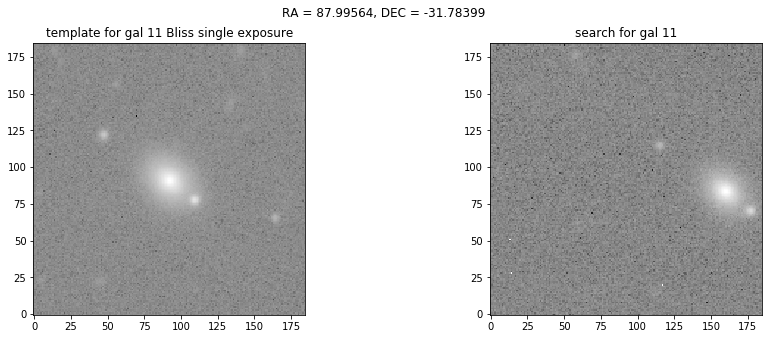

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.3818s]
(RA,DEC)= 88.02982263686918 -31.801256047815038
Filter, mag, magerr r 16.73075 0.0027247574
Opening file: /data/des61.b/data/BLISS/502800/502806/D00502806_r_04_r1p1_immask.fits.fz
cutout: 92 609.3412616689438 1212.2427889476562
trying search + Bliss single exposure



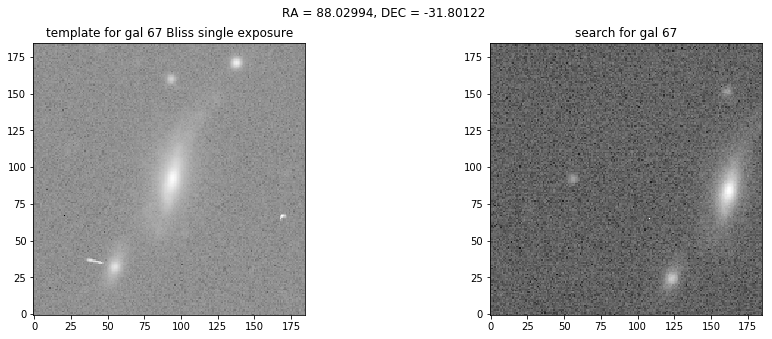

7 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.3612s]
(RA,DEC)= 87.56423064344071 -31.360824063825955
Filter, mag, magerr r 16.477037 0.002223972
Opening file: /data/des61.b/data/BLISS/514200/514253/D00514253_r_24_r1p1_immask.fits.fz
cutout: 92 1740.512184688589 2241.5203165036287
trying search + Bliss single exposure



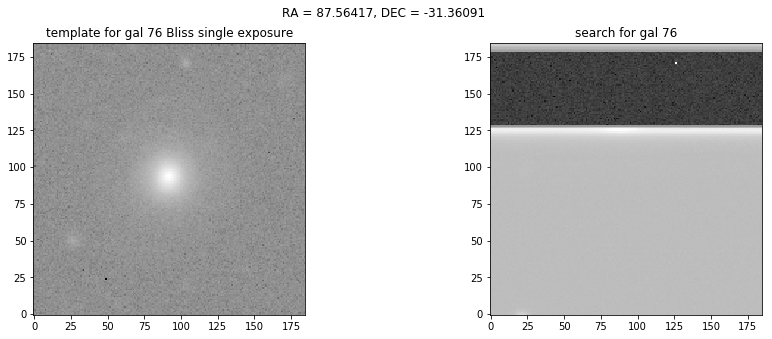

8 9 10 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.6281s]
(RA,DEC)= 88.09010668554406 -31.28357214685973
Filter, mag, magerr r 15.382016 0.00083950016
Opening file: /data/des61.b/data/BLISS/611000/611016/D00611016_r_62_r1p1_immask.fits.fz
cutout: 92 1579.9640506845772 1396.9338051946713
trying search + Bliss single exposure



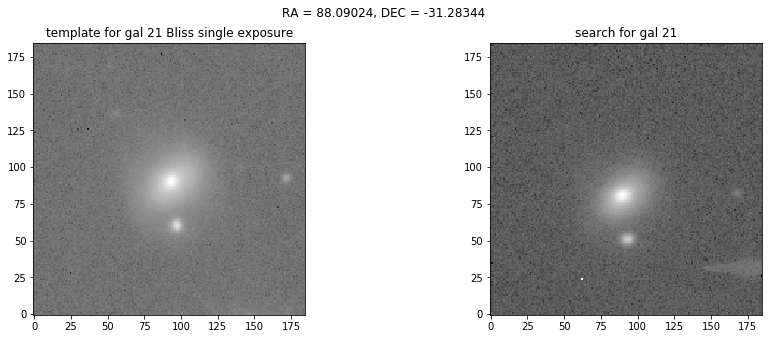

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.6401s]
(RA,DEC)= 88.00919051190202 -31.315536169982835
Filter, mag, magerr r 14.997704 0.0005428687
Opening file: /data/des61.b/data/BLISS/272500/272573/D00272573_r_55_r1p1_immask.fits.fz
cutout: 92 618.5445051467132 1871.1156975867168
trying search + Bliss single exposure



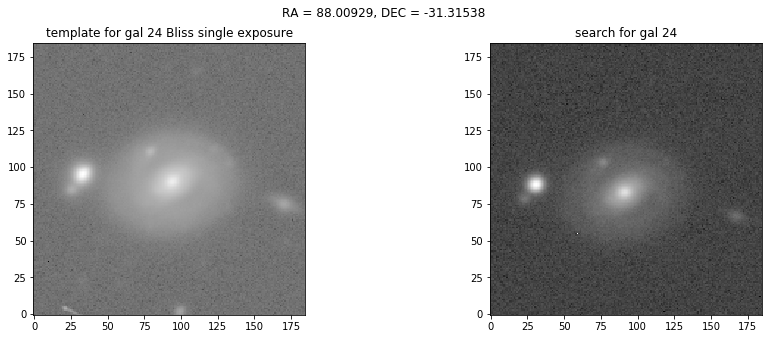

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.5976s]
(RA,DEC)= 88.10490560335283 -31.242450958142005
Filter, mag, magerr r 15.353326 0.0009237421
Opening file: /data/des61.b/data/BLISS/514200/514221/D00514221_r_57_r1p1_immask.fits.fz
cutout: 92 448.80559368865033 822.5800239068354
trying search + Bliss single exposure



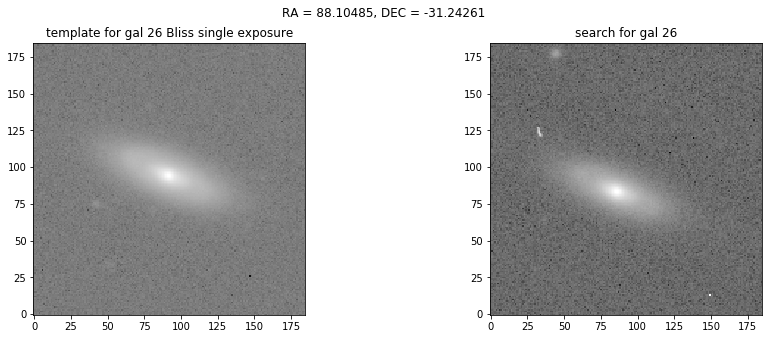

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m22.4194s]
(RA,DEC)= 87.99096972790187 -31.20884892674034
Filter, mag, magerr r 20.922241 0.050852783
Opening file: /data/des61.b/data/BLISS/718600/718652/D00718652_r_41_r1p1_immask.fits.fz
cutout: 92 904.9089732865555 3573.8948804371385
trying search + Bliss single exposure



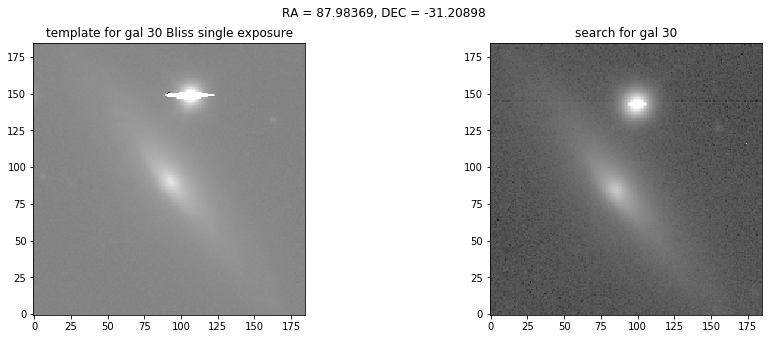

11 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.3642s]
(RA,DEC)= 87.81758803695153 -31.10473579072095
Filter, mag, magerr r 13.393913 0.0003686369
Opening file: /data/des61.b/data/BLISS/514200/514221/D00514221_r_51_r1p1_immask.fits.fz
cutout: 92 820.3185630524649 3827.0999295979836
trying search + Bliss single exposure



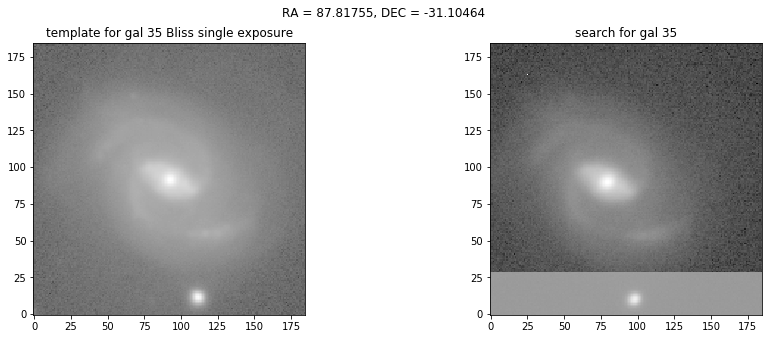

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m18.5355s]
(RA,DEC)= 87.83991438621801 -31.028548045577793
Filter, mag, magerr r 17.991203 0.011862446
Opening file: /data/des61.b/data/BLISS/499100/499168/D00499168_r_60_r1p1_immask.fits.fz
cutout: 92 2016.5176408028601 135.18095925727084
trying search + Bliss single exposure



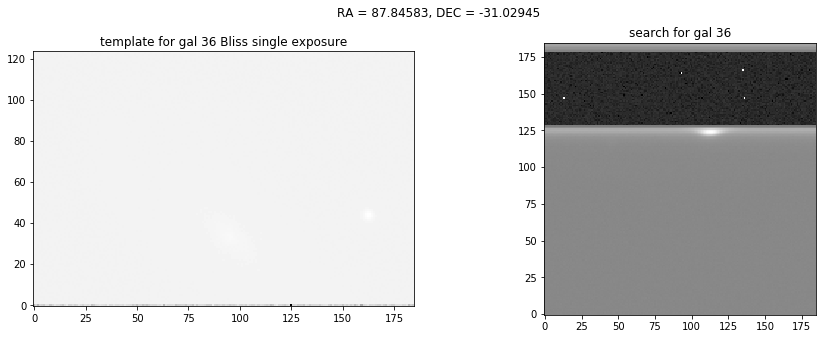

12 13 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.5172s]
(RA,DEC)= 87.58728372415665 -31.98771775842879
Filter, mag, magerr r 15.431295 0.0010849243
Opening file: /data/des61.b/data/BLISS/704900/704921/D00704921_r_53_r1p1_immask.fits.fz
cutout: 92 609.0981950230671 1102.5418204589218
trying search + Bliss single exposure



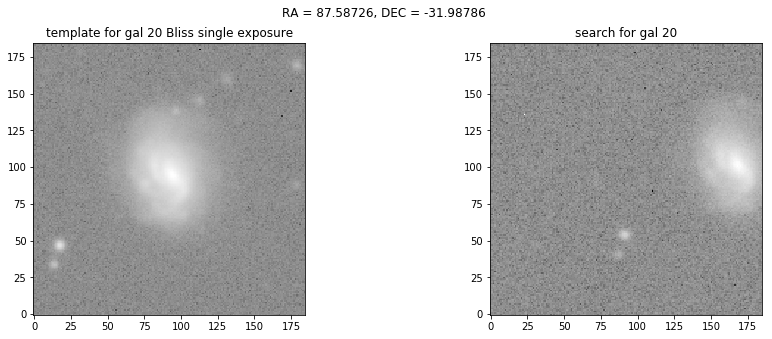

14 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.7719s]
(RA,DEC)= 87.95913124368803 -31.939109953701923
Filter, mag, magerr r 16.127268 0.0015698413
Opening file: /data/des61.b/data/BLISS/502800/502806/D00502806_r_08_r1p1_immask.fits.fz
cutout: 92 249.92436610920413 2525.2635524708253
trying search + Bliss single exposure



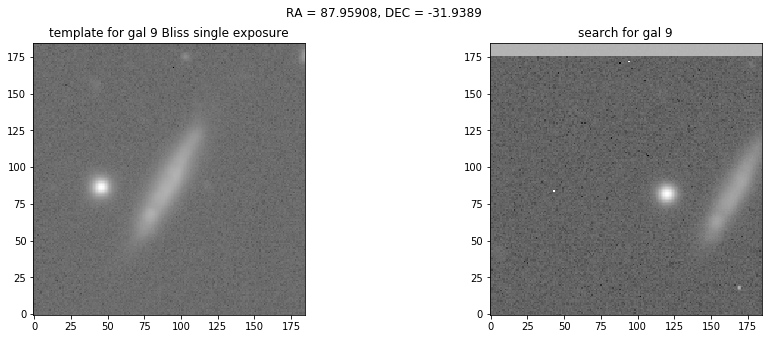

15 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.6073s]
(RA,DEC)= 87.62340339759473 -32.15400752224411
Filter, mag, magerr r 15.82895 0.0015792865
Opening file: /data/des61.b/data/BLISS/597600/597690/D00597690_r_20_r1p1_immask.fits.fz
cutout: 92 1448.957916709429 3769.288416635353
trying search + Bliss single exposure



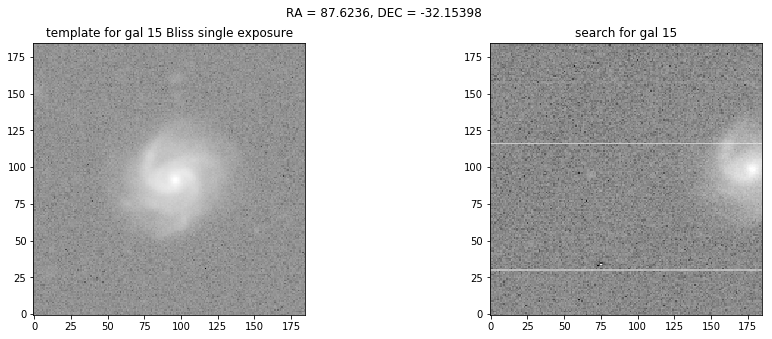

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.3881s]
(RA,DEC)= 87.67053969906354 -32.1376948347912
Filter, mag, magerr r 14.627907 0.0009577439
Opening file: /data/des61.b/data/BLISS/502800/502806/D00502806_r_13_r1p1_immask.fits.fz
cutout: 92 739.6249918276335 1320.0721271596667
trying search + Bliss single exposure



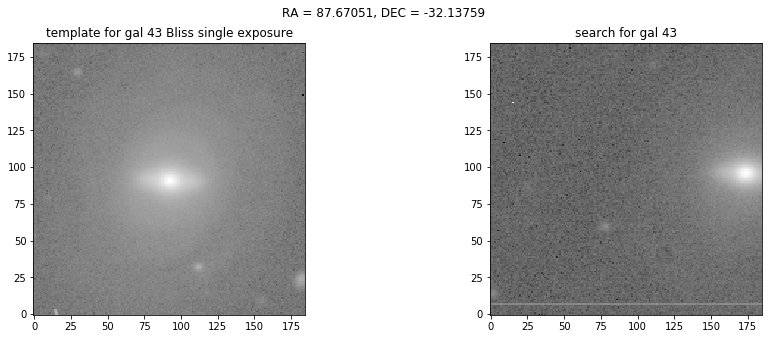

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.1912s]
(RA,DEC)= 87.74225382588706 -32.08042528002876
Filter, mag, magerr r 16.426624 0.0016252456
Opening file: /data/des61.b/data/BLISS/704900/704921/D00704921_r_53_r1p1_immask.fits.fz
cutout: 92 1879.099627906312 2897.01345592145
trying search + Bliss single exposure



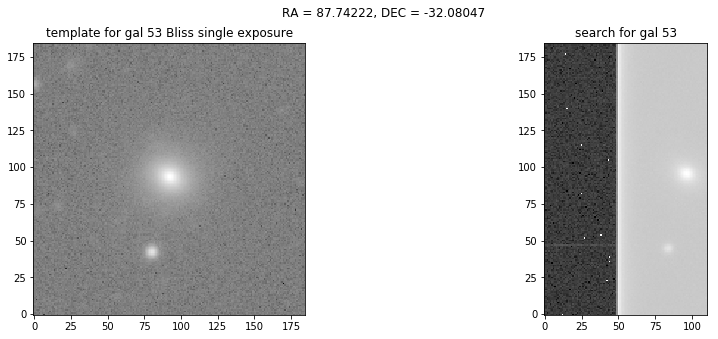

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.1547s]
(RA,DEC)= 87.71522087699928 -32.13899069454423
Filter, mag, magerr r 15.11648 0.0009469134
Opening file: /data/des61.b/data/BLISS/597600/597690/D00597690_r_21_r1p1_immask.fits.fz
cutout: 92 1245.27878944341 578.908274896631
trying search + Bliss single exposure



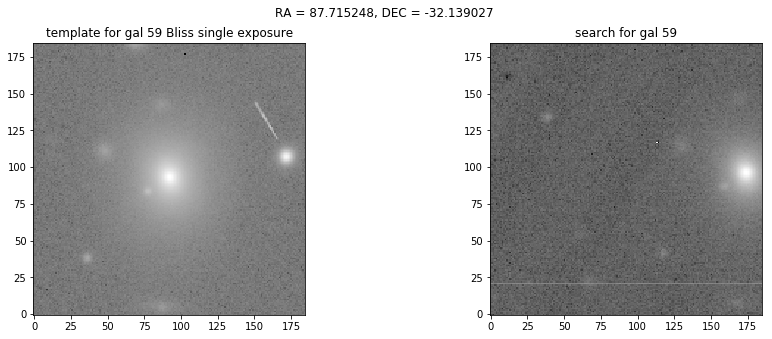

16 17 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.6942s]
(RA,DEC)= 87.63293791726272 -32.31078055604703
Filter, mag, magerr r 15.781662 0.001322059
Opening file: /data/des61.b/data/BLISS/502800/502806/D00502806_r_19_r1p1_immask.fits.fz
cutout: 92 866.2400017877735 903.6747329590423
trying search + Bliss single exposure



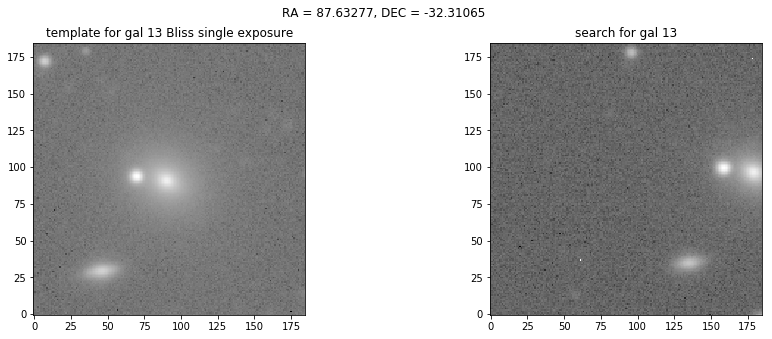

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.1771s]
(RA,DEC)= 87.7316293404574 -32.19689516640838
Filter, mag, magerr r 15.877712 0.0013917442
Opening file: /data/des61.b/data/BLISS/704900/704921/D00704921_r_58_r1p1_immask.fits.fz
cutout: 92 1223.1782247447918 649.4837029734697
trying search + Bliss single exposure



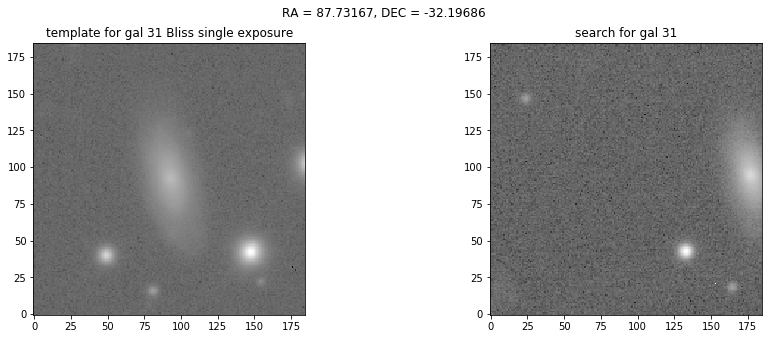

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.3435s]
(RA,DEC)= 87.67347460860199 -32.199714700601916
Filter, mag, magerr r 15.888108 0.0014672356
Opening file: /data/des61.b/data/BLISS/502800/502806/D00502806_r_13_r1p1_immask.fits.fz
cutout: 92 1591.481442284944 1363.0071590113953
trying search + Bliss single exposure



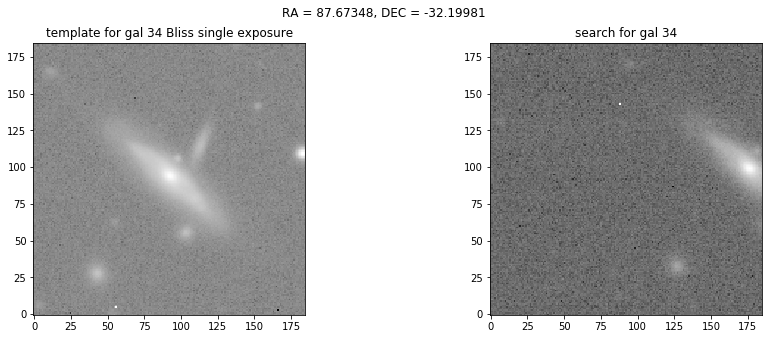

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m19.337s]
(RA,DEC)= 87.67085365177604 -32.24596619974535
Filter, mag, magerr r 22.579296 0.13890047
Opening file: /data/des61.b/data/BLISS/714200/714221/D00714221_r_04_r1p1_immask.fits.fz
cutout: 92 891.8236910743508 1304.2879197066807
trying search + Bliss single exposure



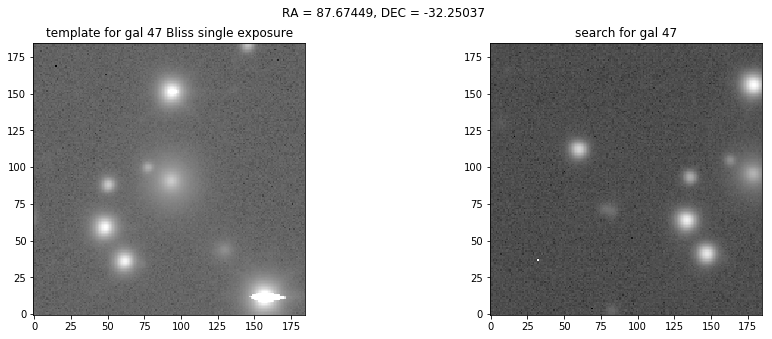

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.5139s]
(RA,DEC)= 87.63549666317503 -32.26525749101267
Filter, mag, magerr r 16.068718 0.0013741865
Opening file: /data/des61.b/data/BLISS/597600/597690/D00597690_r_27_r1p1_immask.fits.fz
cutout: 92 720.6718669029128 1784.9326646300046
trying search + Bliss single exposure



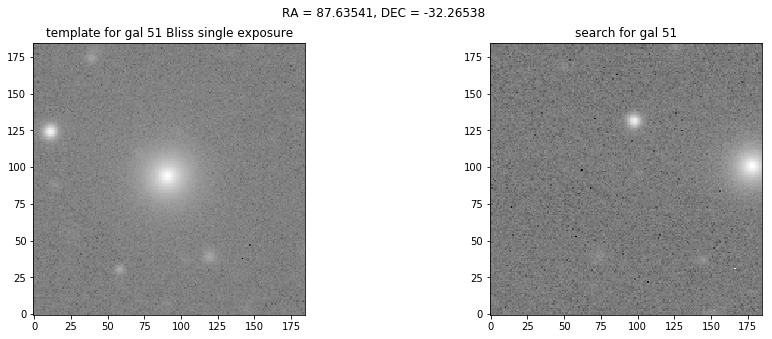

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.0618s]
(RA,DEC)= 87.88732680415006 -32.24354214076847
Filter, mag, magerr r 14.688654 0.00083179196
Opening file: /data/des61.b/data/BLISS/597600/597690/D00597690_r_28_r1p1_immask.fits.fz
cutout: 92 419.7286969994291 441.2405825477325
trying search + Bliss single exposure



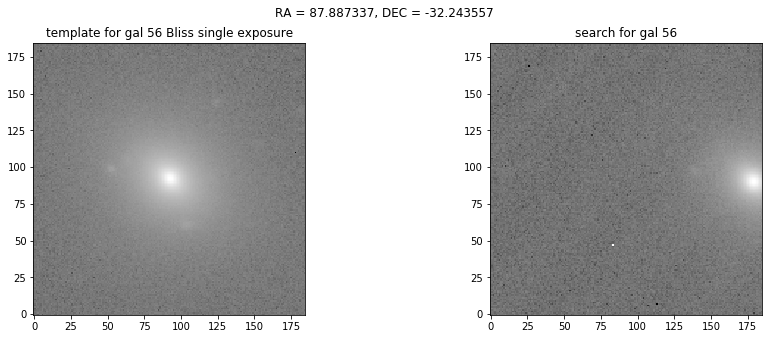

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.0411s]
(RA,DEC)= 87.7734923690136 -32.21134392785919
Filter, mag, magerr r 16.272182 0.0018542804
Opening file: /data/des61.b/data/BLISS/714200/714221/D00714221_r_04_r1p1_immask.fits.fz
cutout: 92 352.7265966347841 2448.299354696784
trying search + Bliss single exposure



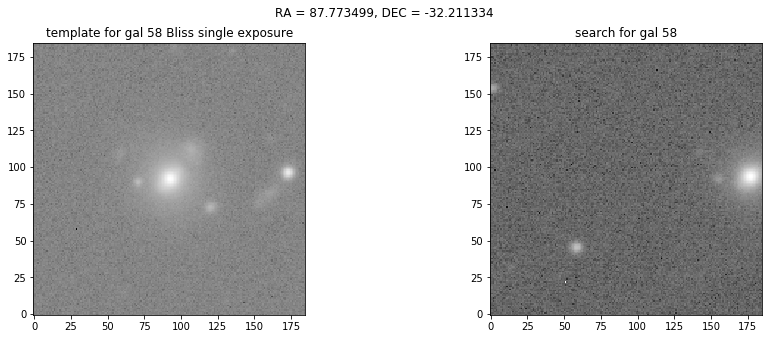

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.0173s]
(RA,DEC)= 87.70033603901233 -32.27488295414796
Filter, mag, magerr r 15.739136 0.0013475852
Opening file: /data/des61.b/data/BLISS/502800/502806/D00502806_r_19_r1p1_immask.fits.fz
cutout: 92 370.9279527943677 1682.9282444747284
trying search + Bliss single exposure



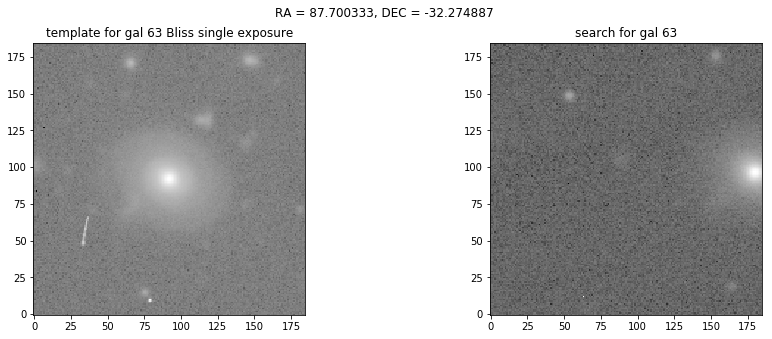

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.3686s]
(RA,DEC)= 87.6988917959442 -32.25439544751358
Filter, mag, magerr r 16.412668 0.0017593153
Opening file: /data/des61.b/data/BLISS/714200/714221/D00714221_r_04_r1p1_immask.fits.fz
cutout: 92 945.3402039622397 1586.199083633478
trying search + Bliss single exposure



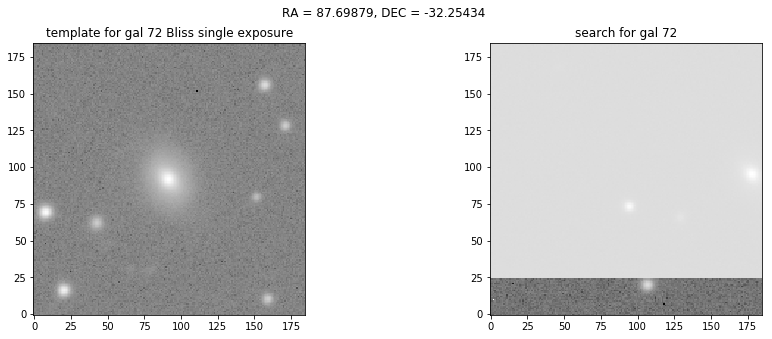

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.5106s]
(RA,DEC)= 87.66907775277849 -32.2712094810937
Filter, mag, magerr r 14.30933 0.0009897717
Opening file: /data/des61.b/data/BLISS/502800/502806/D00502806_r_19_r1p1_immask.fits.fz
cutout: 92 323.1757309365248 1317.8271580798532
trying search + Bliss single exposure



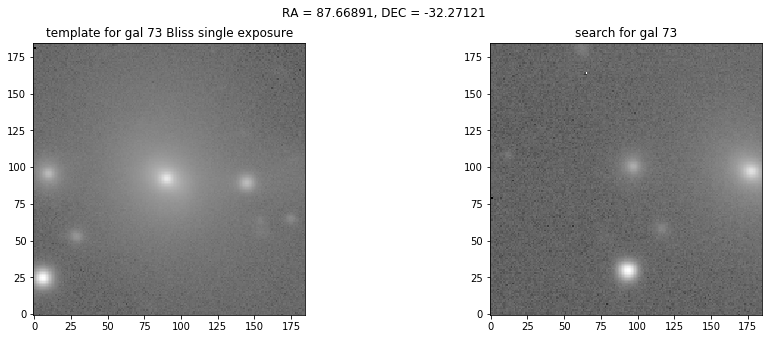

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.3622s]
(RA,DEC)= 87.92016276250789 -32.21770125694495
Filter, mag, magerr r 16.22716 0.0014889106
Opening file: /data/des61.b/data/BLISS/704900/704921/D00704921_r_58_r1p1_immask.fits.fz
cutout: 92 1518.0213919723737 2830.255556424078
trying search + Bliss single exposure



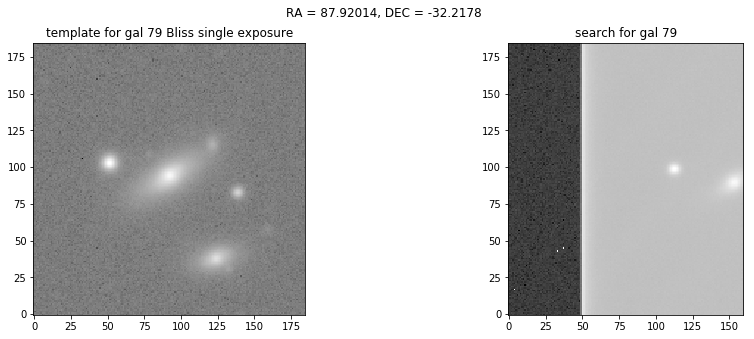

18 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.4517s]
(RA,DEC)= 87.92136728742034 -32.354369382506796
Filter, mag, magerr r 16.135332 0.0014905492
Opening file: /data/des61.b/data/BLISS/597600/597690/D00597690_r_28_r1p1_immask.fits.fz
cutout: 92 1933.5113200315138 835.3345829110887
trying search + Bliss single exposure



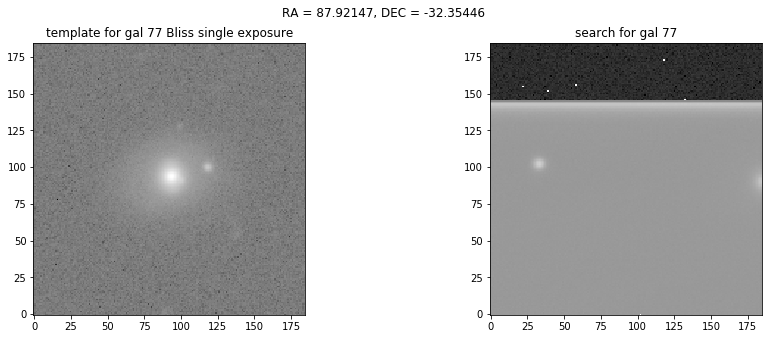

19 20 21 22 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.3054s]
(RA,DEC)= 89.23733319894608 -31.49459831608135
Filter, mag, magerr r 16.559822 0.002513976
Opening file: /data/des61.b/data/BLISS/714900/714905/D00714905_r_01_r1p1_immask.fits.fz
cutout: 92 438.76145224013453 3436.045434507429
trying search + Bliss single exposure



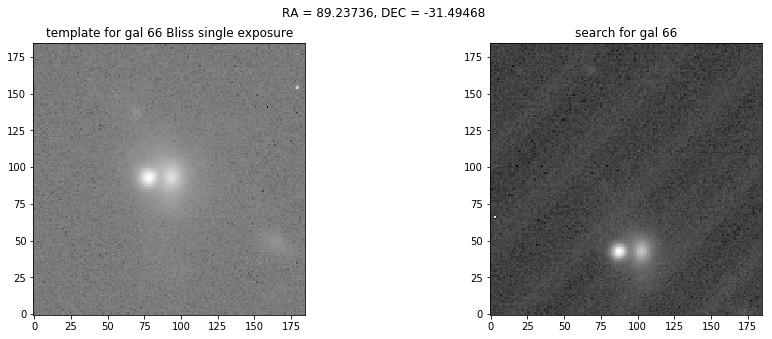

23 24 25 26 27 28 29 30 31 32 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.2524s]
(RA,DEC)= 88.543733259168 -30.905658819385124
Filter, mag, magerr r 16.488335 0.002266363
Opening file: /data/des61.b/data/BLISS/612700/612722/D00612722_r_45_r1p1_immask.fits.fz
cutout: 92 1966.3702570592513 2493.7112486358424
trying search + Bliss single exposure



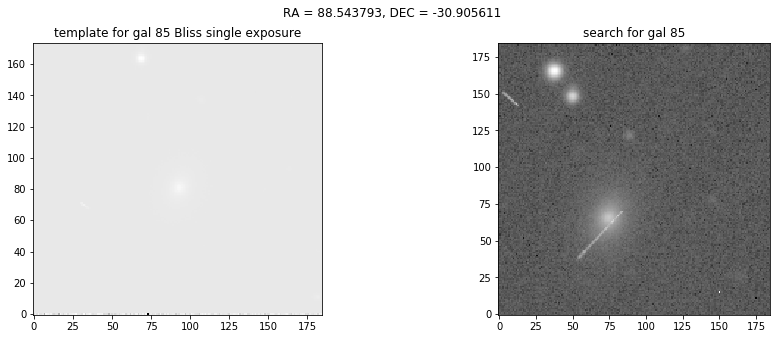

33 34 35 36 37 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.1586s]
(RA,DEC)= 88.49786801477693 -31.76809988818163
Filter, mag, magerr r 16.719093 0.0022285946
Opening file: /data/des61.b/data/BLISS/718600/718652/D00718652_r_59_r1p1_immask.fits.fz
cutout: 92 1830.2452912692788 1052.958899331191
trying search + Bliss single exposure



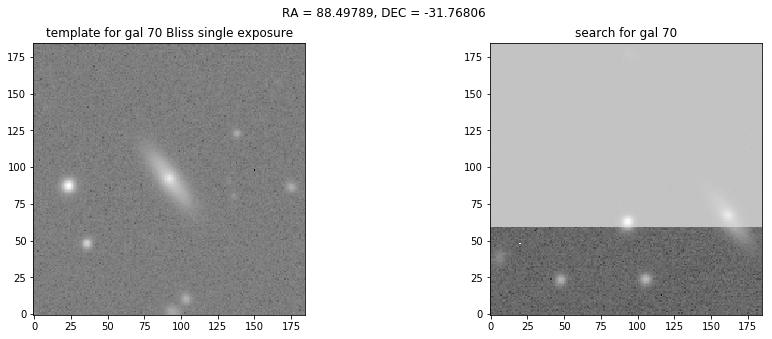

38 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.1904s]
(RA,DEC)= 88.7306679024016 -31.77882674747312
Filter, mag, magerr r 16.571507 0.0017744454
Opening file: /data/des61.b/data/BLISS/502800/502806/D00502806_r_06_r1p1_immask.fits.fz
cutout: 92 294.90511514115497 862.2987666279821
trying search + Bliss single exposure



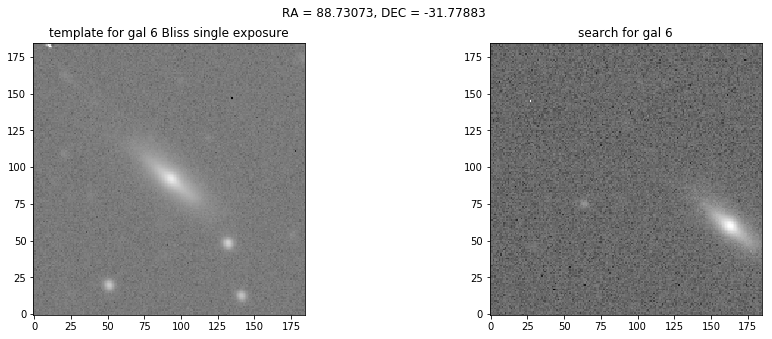

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.1328s]
(RA,DEC)= 88.71572048431597 -31.771082505026218
Filter, mag, magerr r 15.806395 0.0015690128
Opening file: /data/des61.b/data/BLISS/718600/718652/D00718652_r_59_r1p1_immask.fits.fz
cutout: 92 1891.0306014858888 3589.392480668227
trying search + Bliss single exposure



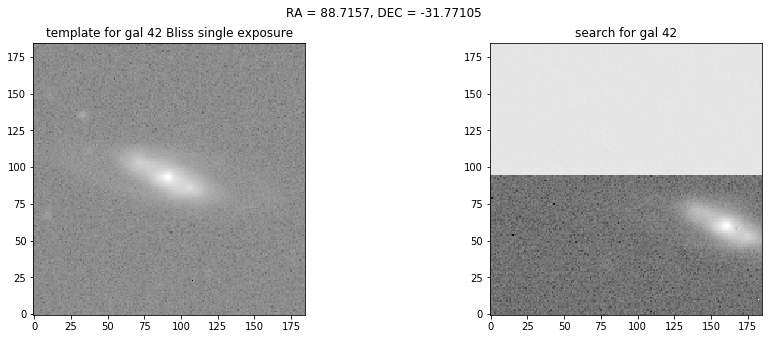

39 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.4618s]
(RA,DEC)= 89.38209475387481 -31.750638181660797
Filter, mag, magerr r 15.708105 0.0010336763
Opening file: /data/des61.b/data/BLISS/704900/704924/D00704924_r_20_r1p1_immask.fits.fz
cutout: 92 1230.2230858659323 755.9634423363628
trying search + Bliss single exposure



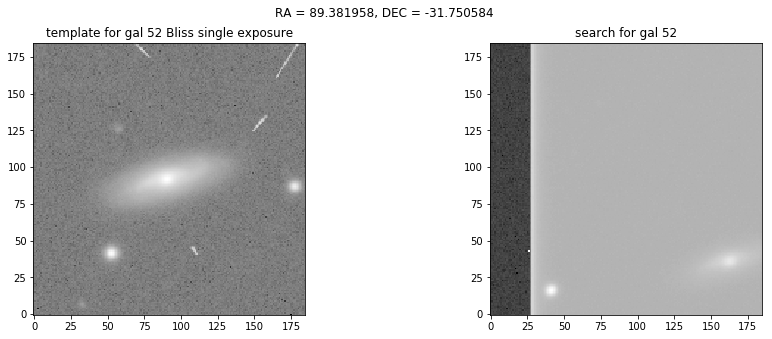

40 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.0947s]
(RA,DEC)= 89.70212886059377 -31.78833371476034
Filter, mag, magerr r 14.768531 0.0008317437
Opening file: /data/des61.b/data/BLISS/597600/597691/D00597691_r_47_r1p1_immask.fits.fz
cutout: 92 1312.021774360397 3265.3677372968664
trying search + Bliss single exposure



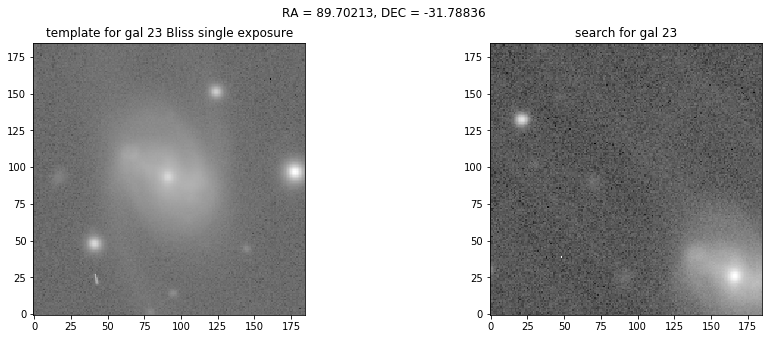

41 42 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m26.4973s]
(RA,DEC)= 88.76695477455682 -31.63360335491679
Filter, mag, magerr r 22.040524 0.105925106
Opening file: /data/des61.b/data/BLISS/714900/714905/D00714905_r_04_r1p1_immask.fits.fz
cutout: 92 10.060947952928473 94.92316021445204
trying search + Bliss single exposure

43 44 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.2758s]
(RA,DEC)= 89.4583656477287 -31.663352396868614
Filter, mag, magerr r 16.969767 0.0022667244
Opening file: /data/des61.b/data/BLISS/502100/502114/D00502114_r_32_r1p1_immask.fits.fz
cutout: 92 1384.8942950885087 3858.3999504323883
trying search + Bliss single exposure



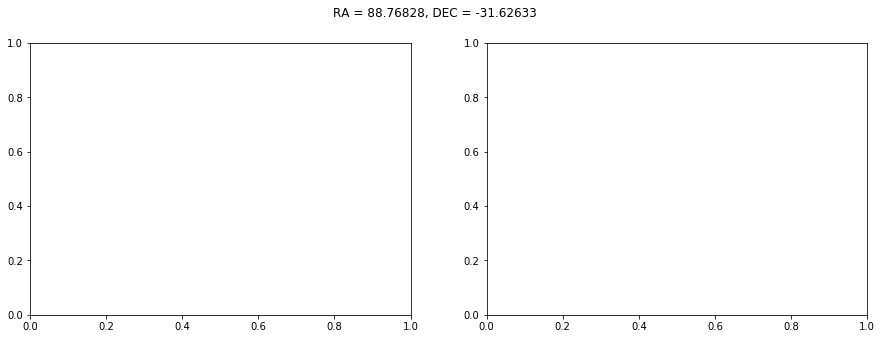

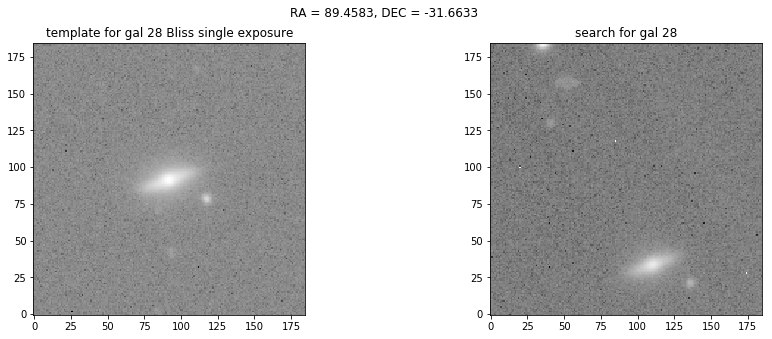

45 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.5626s]
(RA,DEC)= 88.30182314000531 -31.93847273334475
Filter, mag, magerr r 16.093113 0.0016582133
Opening file: /data/des61.b/data/BLISS/502800/502806/D00502806_r_09_r1p1_immask.fits.fz
cutout: 92 236.55906043471623 2258.7330571328844
trying search + Bliss single exposure



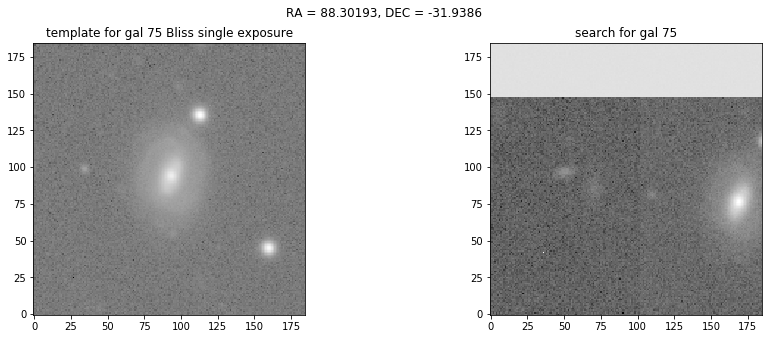

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.1921s]
(RA,DEC)= 88.34922417859671 -31.979895726592495
Filter, mag, magerr r 16.160233 0.0024941787
Opening file: /data/des61.b/data/BLISS/502800/502806/D00502806_r_09_r1p1_immask.fits.fz
cutout: 92 802.1816964794652 2810.1282297582616
trying search + Bliss single exposure



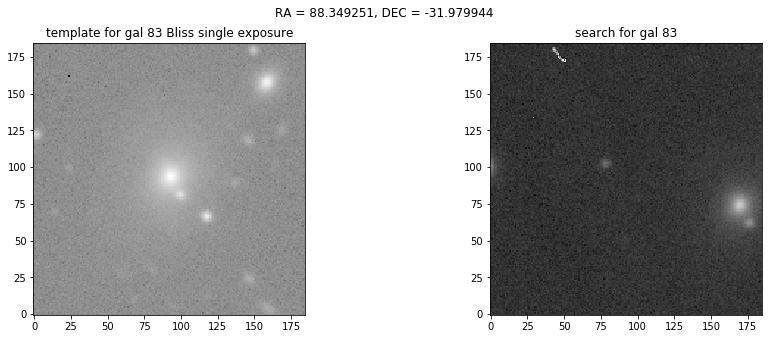

46 47 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.82s]
(RA,DEC)= 89.00504896811132 -31.90487125374041
Filter, mag, magerr r 15.613962 0.0011490374
Opening file: /data/des61.b/data/BLISS/704900/704924/D00704924_r_25_r1p1_immask.fits.fz
cutout: 92 1119.6744025816586 2751.379938294518
trying search + Bliss single exposure



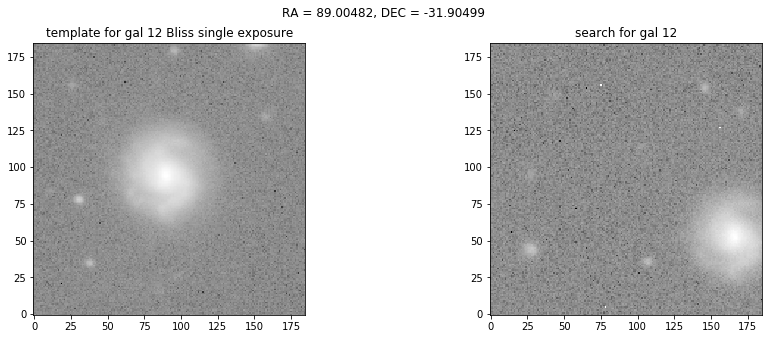

48 49 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.7026s]
(RA,DEC)= 88.96730751204886 -32.06463584290118
Filter, mag, magerr r 14.966416 0.0010096545
Opening file: /data/des61.b/data/BLISS/597600/597690/D00597690_r_24_r1p1_immask.fits.fz
cutout: 92 273.60088589497263 2331.9431030739406
trying search + Bliss single exposure



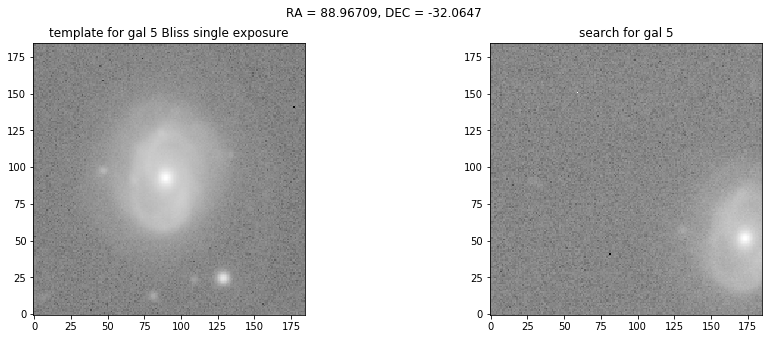

50 51 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.7507s]
(RA,DEC)= 88.42897743066362 -32.095884964138335
Filter, mag, magerr r 15.465789 0.00116371
Opening file: /data/des61.b/data/BLISS/502800/502806/D00502806_r_15_r1p1_immask.fits.fz
cutout: 92 139.99801617264166 1611.3662963550826
trying search + Bliss single exposure



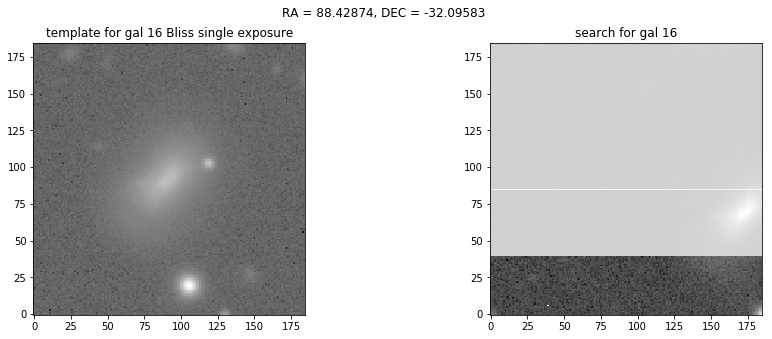

52 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.268s]
(RA,DEC)= 88.59615573317792 -32.137492416522456
Filter, mag, magerr r 15.962277 0.0018074203
Opening file: /data/des61.b/data/BLISS/714900/714905/D00714905_r_19_r1p1_immask.fits.fz
cutout: 92 277.0250302726063 2395.113261636747
trying search + Bliss single exposure



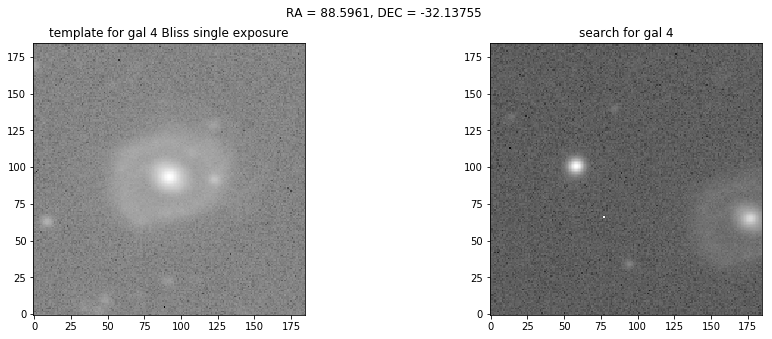

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.3522s]
(RA,DEC)= 88.77425323987497 -32.06262280510599
Filter, mag, magerr r 15.462091 0.0012609465
Opening file: /data/des61.b/data/BLISS/714900/714905/D00714905_r_14_r1p1_immask.fits.fz
cutout: 92 1491.1275773850502 210.0802982698142
trying search + Bliss single exposure



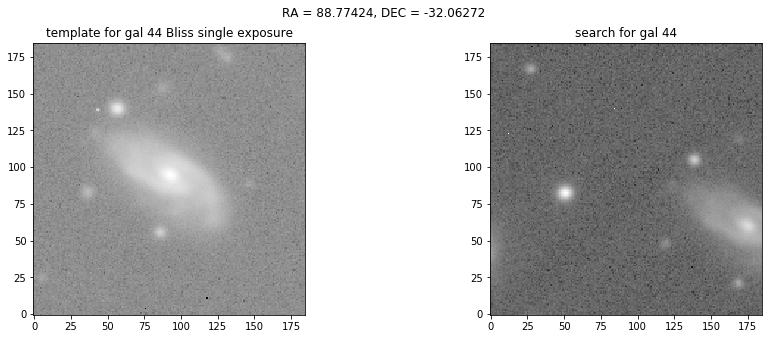

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.4782s]
(RA,DEC)= 88.5934194096809 -32.17711832175676
Filter, mag, magerr r 16.445032 0.0017041051
Opening file: /data/des61.b/data/BLISS/714900/714905/D00714905_r_19_r1p1_immask.fits.fz
cutout: 92 816.9991079118054 2368.9978539328336
trying search + Bliss single exposure



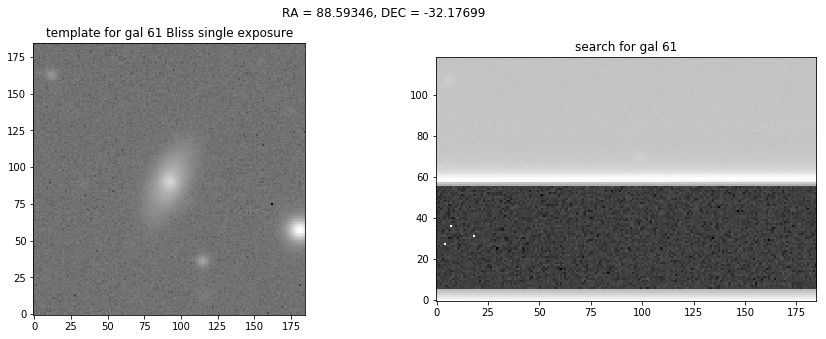

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.0573s]
(RA,DEC)= 88.49758504408146 -32.1488184523378
Filter, mag, magerr r 15.620581 0.001010771
Opening file: /data/des61.b/data/BLISS/597600/597690/D00597690_r_23_r1p1_immask.fits.fz
cutout: 92 1391.0984988607615 1122.0427710166855
trying search + Bliss single exposure



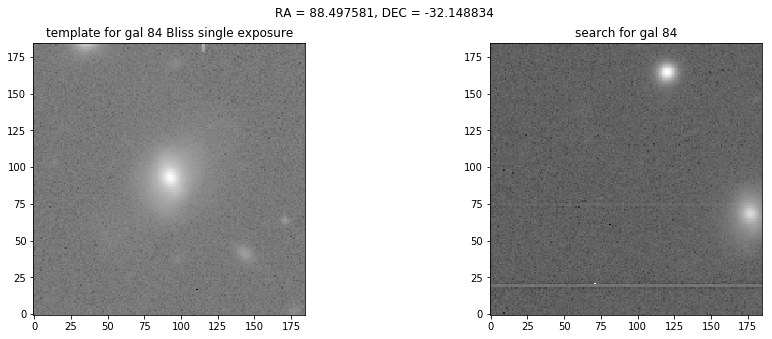

53 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.1959s]
(RA,DEC)= 87.97569912360493 -32.19978857549272
Filter, mag, magerr r 15.914382 0.0016944606
Opening file: /data/des61.b/data/BLISS/704900/704921/D00704921_r_58_r1p1_immask.fits.fz
cutout: 92 1274.3548867827867 3473.555793583088
trying search + Bliss single exposure



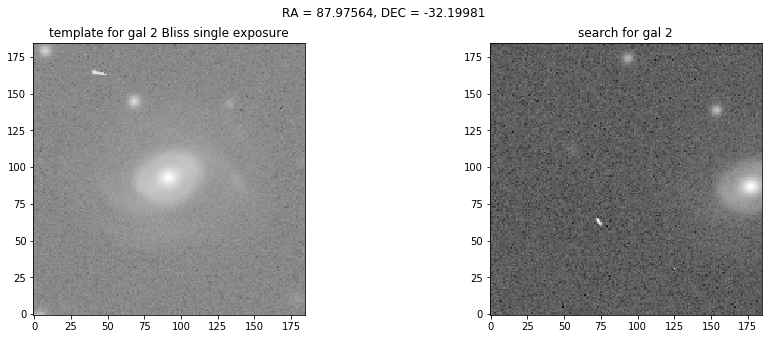

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m01.2862s]
(RA,DEC)= 87.97569912360493 -32.19978857549272
Filter, mag, magerr r 15.914382 0.0016944606
Opening file: /data/des61.b/data/BLISS/704900/704921/D00704921_r_58_r1p1_immask.fits.fz
cutout: 92 1272.0220737703858 3478.68141088158
trying search + Bliss single exposure



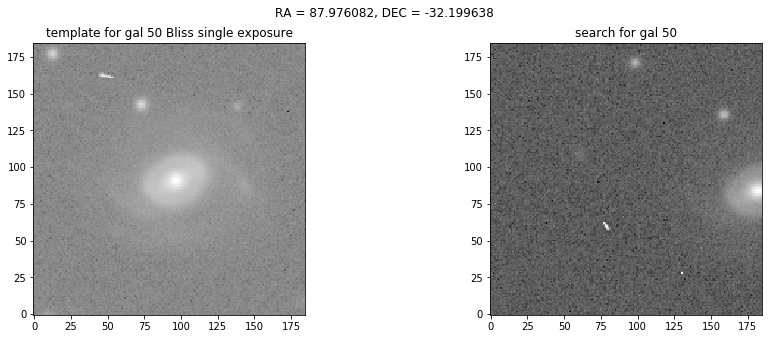

54 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.3011s]
(RA,DEC)= 88.37381421783806 -32.22865526745584
Filter, mag, magerr r 16.081593 0.001375246
Opening file: /data/des61.b/data/BLISS/704900/704921/D00704921_r_59_r1p1_immask.fits.fz
cutout: 92 1701.5213217815308 3835.757237658301
trying search + Bliss single exposure



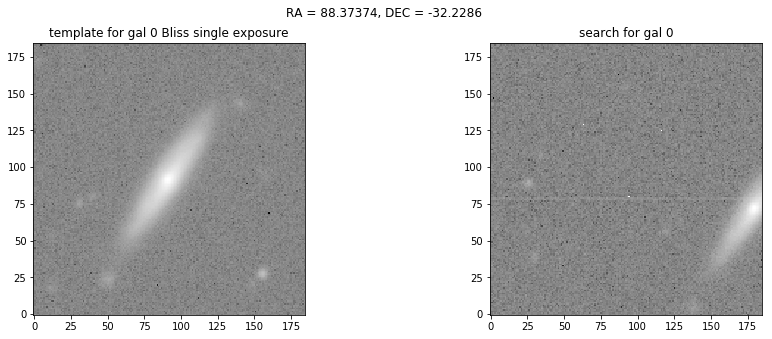

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.2302s]
(RA,DEC)= 88.40214644504157 -32.27737990327376
Filter, mag, magerr r 15.426372 0.001211615
Opening file: /data/des61.b/data/BLISS/714200/714221/D00714221_r_06_r1p1_immask.fits.fz
cutout: 92 1257.9356866279195 1223.7921507884844
trying search + Bliss single exposure



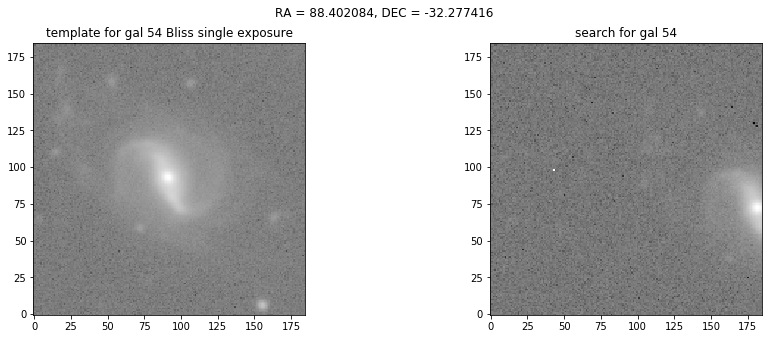

55 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m09.6928s]
(RA,DEC)= 88.71706020442842 -32.326487709596
Filter, mag, magerr r 18.235807 0.0065969178
Opening file: /data/des61.b/data/BLISS/597600/597690/D00597690_r_30_r1p1_immask.fits.fz
cutout: 92 1581.820240137931 1483.7223564383182
trying search + Bliss single exposure



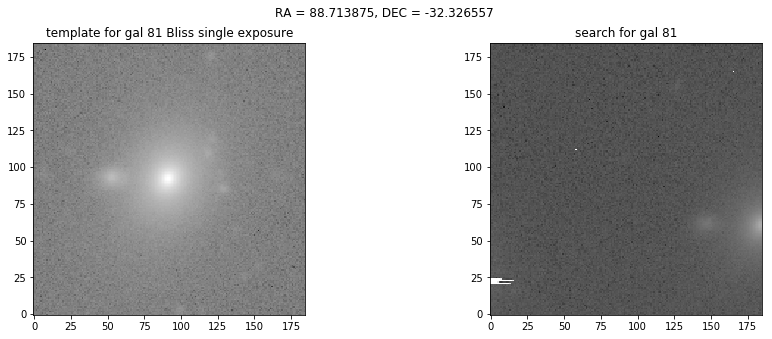

56 57 58 cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.497s]
(RA,DEC)= 88.7546224292671 -32.35950758259226
Filter, mag, magerr r 16.60244 0.0018460925
Opening file: /data/des61.b/data/BLISS/612700/612726/D00612726_r_25_r1p1_immask.fits.fz
cutout: 92 856.6295096252172 3950.901598392788
trying search + Bliss single exposure



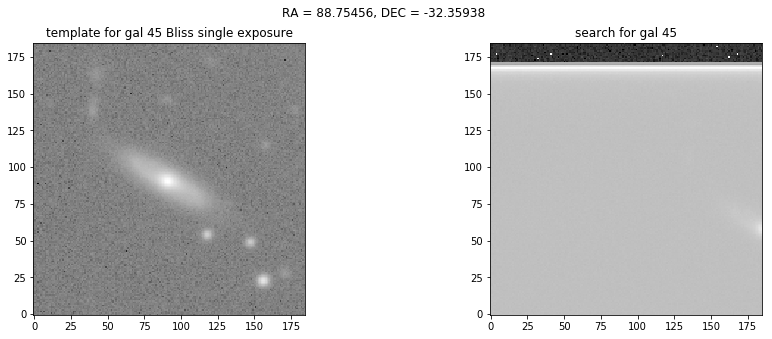

cutout: 92 92 92 x,y len 2160 4146
Exposure available in  r
Closest object is at distance [0d00m00.3402s]
(RA,DEC)= 88.63184905786747 -32.47190204037183
Filter, mag, magerr r 16.52821 0.0016892152
Opening file: /data/des61.b/data/BLISS/597600/597690/D00597690_r_37_r1p1_immask.fits.fz
cutout: 92 1314.1534448956122 527.8735931928471
trying search + Bliss single exposure



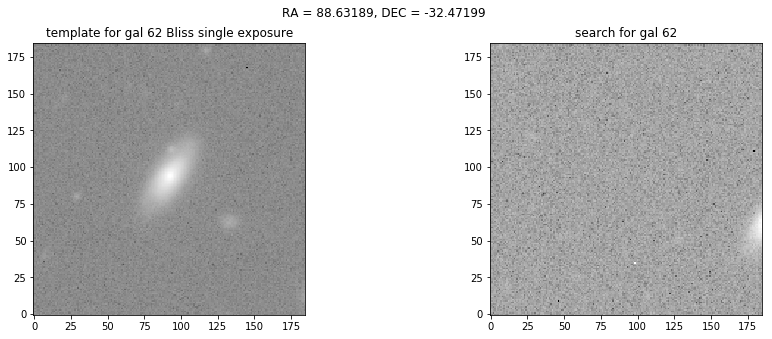

59 60 61 62 did 61 galaxies!


In [65]:
image_ra, image_dec = 88.48695,-31.68361
image_name = "856764"; filter="r"

work_image(image_name, image_ra,image_dec, filter=filter, do_bliss=True, do_cutout=False, verbose=True)

# Do the Eyeballing!

This is the action cell!

For a given image, get the 
image name, ra, dec

Change the triplets,
then run the cell, it will take time to do all of them

Exposure available in  g
Closest object is at distance [0d00m00.425s]
(RA,DEC)= 87.99563215539527 -31.78410788000979
Filter, mag, magerr g 17.56227 0.0035836191
Opening file: /data/des60.b/data/BLISS/598300/598368/D00598368_g_10_r1p1_immask.fits.fz
cutout: 55 899.191496296753 1716.0683675197808
Opening file: /data/des51.b/data/DTS/src/20190510/DECam_00856743.fits.fz
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 Not Found


TypeError: Invalid dimensions for image data

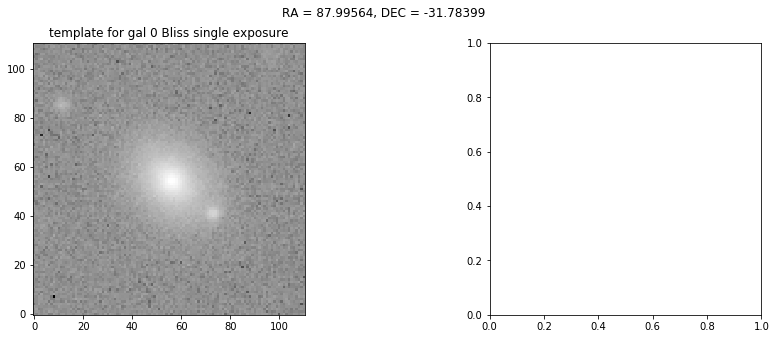

In [99]:
image_ra, image_dec = 87.42528, -30.7226
image_name = "DECam_00856743.fits.fz"
gra,gdec,thumbs = get_list_of_gals_and_cutouts(image_ra, image_dec)

#gra,gdec = np.ones(2)*image_ra, np.ones(2)*image_dec
#thumbs[0] = 'DESJ054942.1-304321.4'
#thumbs[1] = 'DESJ054942.1-304321.4'


pixscal=.27
for i in range(gra.size) :
    fig,axs=plt.subplots(1,2,figsize=(15,5))
    axs=axs.ravel()
    fig.suptitle('RA = '+str(round(gra[i],6))+', DEC = '+str(round(gdec[i],6)))
    
    match_cutout = 15
    go_big = 25
    if i == 1 :
        template = get_des_cutout_image(thumbs[i])
        label = "DES coadd"
        size = match_cutout/0.27
    
    if i == 0:
        template = find_BLISS_image(gra[i],gdec[i],size)
        label = "Bliss single exposure"
        size = go_big/0.27
    search = find_search_image(image_name,gra[i],gdec[i],size)
    #print search
    #if search == -1 or search == []: continue

    
    axs[0].imshow(np.log10(template-np.amin(template)+1),origin='lower',cmap='gray')
    axs[0].set_title('template for gal {} {}'.format(i, label))
    axs[1].imshow(np.log10(search-np.amin(search)+1),origin='lower',cmap='gray')
    axs[1].set_title('search for gal {}'.format(i))
    plt.show()

In [ ]:

# save new cutout to new folder
def get_search_image(RA,DEC,size,
                     fname="DECam_00850304.fits.fz",
                     path="/data/des51.b/data/DTS/src/20190509/"):
    # open new file
    hdul=fits.open(fname)
    header0=hdul[0].header
    
    for hdu in hdul[1:]:
        header=hdu.header
        img=np.array(hdu.data)
        
        # Parse the WCS keywords in the primary HDU
        w = wcs.WCS(header)
    
        wcoords=np.array([RA,DEC]).reshape((1,2))
        pixs=w.all_world2pix(wcoords,1)[0]
        
        if 0<=pixs[0]<img.shape[1] and 0<=pixs[1]<img.shape[0]:
            
            cutout=np.flip(np.flip(np.array(img[int(max(0,pixs[1]-size/2.)):int(min(img.shape[0],pixs[1]+size/2.)),
                            int(max(0,pixs[0]-size/2.)):int(min(img.shape[1],pixs[0]+size/2.))]),1).transpose(),1)
            
            #write file
            new_filename=path+'RA'+str(RA)+'_DEC'+str(DEC)+'.fits'
            try: fits.writeto(new_filename, cutout, header)
            except OSError:
                try:
                    os.remove(new_filename)
                    fits.writeto(new_filename, cutout, header)
                except OSError:
                    print('file saving error with '+str(RA)+', '+str(DEC))

            return cutout
        
    return 'coordinates not found'

In [ ]:
# example data

new_path='./new_images/'
RA_ls=[88.76485]
DEC_ls=[-33.14772]
    
pixscal=.27
for i in range(len(file_ls)):
    fig,axs=plt.subplots(1,2,figsize=(15,5))
    axs=axs.ravel()
    fig.suptitle('RA = '+str(round(RA_ls[i],6))+', DEC = '+str(round(DEC_ls[i],6)))
    
#     if not os.path.isfile(template_path+'RA'+str(round(RA_ls[i],5))+'_DEC'+str(round(DEC_ls[i],5))+'.fits'):
    #template_cutout=ps1.get_ps1_template_image(round(RA_ls[i],6),round(DEC_ls[i],6),300,browser,new_path)
    template_cutout=ps1.get_ps1_template_image(round(RA_ls[i],6),round(DEC_ls[i],6),300,browser,new_path)
    
#     if not os.path.isfile(new_path+'RA'+str(round(RA_ls[i],5))+'_DEC'+str(round(DEC_ls[i],5))+'.fits'):
    new_cutout=get_search_image(round(RA_ls[i],6),round(DEC_ls[i],6),300,original_path+file_ls[i],template_path)
#     new_cutout=np.array(new_cutout)
    
    axs[0].imshow(np.log10(template_cutout-np.amin(template_cutout)+1),origin='lower',cmap='gray')
    axs[0].set_title('template')
    axs[1].imshow(np.log10(new_cutout-np.amin(new_cutout)+1),origin='lower',cmap='gray')
    axs[1].set_title('new')
    plt.show()

In [ ]:
#Antonella's changes 04/29/2019 to make this work with BLISS images
#This part also finds if there are previous detections of the candidate!

In [ ]:
%matplotlib inline
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
import healpy as hp
import os
import numpy as np
import matplotlib.pyplot as plt
from math import fabs
import numpy as np
from astropy.wcs import WCS


def cutout(infilename,ra,dec,stampSize, outfile): #Stampsize is half width
    
    ptsInside2Rp = []
    print("Opening file: " + infilename)
    hdulist = fits.open(infilename)
    header = fits.open(infilename)[1].header #pyfits.getheader(infilename, 0)
    data = fits.open(infilename)[1].data
    ylen, xlen = data.shape[0], data.shape[1]
    
    #Find pixel at the candidate ra dec
    w = WCS(header=header) 
    px, py = w.all_world2pix(ra, dec, 1)
    objcoord = [px, py]

    X = int(px)
    Y = int(py)
    
    #cutting image:
    
    sizy = np.min(np.array([stampSize, fabs(ylen-stampSize)]))
    sizx = np.min(np.array([stampSize, fabs(xlen-stampSize)]))  
    siz = int(np.min(np.array([sizy,sizx])))
    print siz,px,py

    data = data[Y-siz:Y+siz+1,X-siz:X+siz+1]  

    plt.imshow(data, origin='lower',cmap='gray')
    plt.title('RA='+str(ra)+', DEC='+str(dec))
    #Save outfile

def find_BLISS_image(cand_ra,cand_dec,stampSize):
    
    bands = ['g','r','i','z']
    cat_path = '/data/des81.a/data/luidhy/BLISS_allsky_try1/hpx/' 
    exp_path1 = '/data/des50.b/data/BLISS/'
    exp_path2 = '/data/des60.b/data/BLISS/'
    exp_path3 = '/data/des61.b/data/BLISS/'
    cat_nside = 32

    hpix = hp.ang2pix(cat_nside, cand_ra, cand_dec,lonlat=True)

    for band in bands:
        if hpix<10000:
            cat_file = cat_path+band+"/hpx_"+band+"_0"+str(hpix)+".fits"
        else:
            cat_file = cat_path+band+"/hpx_"+band+"_"+str(hpix)+".fits"
        if os.path.isfile(cat_file):
            h=fits.open(cat_file)[1].data
            print "Exposure available in ",band
            c1 = SkyCoord(cand_ra*u.deg, cand_dec*u.deg, frame='fk5')
            cat = SkyCoord(h['RA']*u.deg, h['DEC']*u.deg, frame='fk5')
            idx, d2d, d3d = c1.match_to_catalog_sky(cat)
            print "Closest object is at distance", d2d
            print "(RA,DEC)=",h['RA'][idx], h['DEC'][idx]
            print "Filter, mag, magerr", band, h['MAG_AUTO'][idx], h['MAGERR_AUTO'][idx]
            expnum = h['EXPNUM'][idx]
            ccdnum = h['CCDNUM'][idx]
            exp_fold = str(expnum)[:-2]+"00/"
            if (ccdnum<10): 
                ccdnum_str = "0"+str(ccdnum)
            else: 
                ccdnum_str = str(ccdnum)

            #Now open image

            exp_file1 = exp_path1+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"
            exp_file2 = exp_path2+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"
            exp_file3 = exp_path3+exp_fold+str(expnum)+"/D00"+str(expnum)+"_"+band+"_"+ccdnum_str+"_r1p1_immask.fits.fz"

            if os.path.isfile(exp_file1):
                exp_file = exp_file1
            elif os.path.isfile(exp_file2):
                exp_file = exp_file2
            elif os.path.isfile(exp_file3):
                exp_file = exp_file3
            else:
                print "Error: no exposure found in any path"
                exp_file = 0      

            #If image was found, make a cutout
            if (exp_file!=0):
                outfile = './cutouts/'+str(int(cand_ra))+str(int(cand_dec))+band+'.fits'
                cutout(exp_file,cand_ra,cand_dec,stampSize,outfile) #cand_ra,cand_dec

        else:
            print "There is no source catalog in ", band
            exp_file = 0

In [ ]:
# This is where the cutout is given:

# Your inputs here
cand_ra = 88.764850  #J2000 deg, [0,360]
cand_dec =33.147720 #J2000 deg
#cand_ra = 340.394736 #340.3957286881805 # #J2000 deg, [0,360]
#cand_dec = 7.6819850 #7.681786834893399 #J2000 deg
#cand_ra = 255.58   #J2000 deg, [0,360]
#cand_dec = -12.48562   #J2000 deg
stampSize = 20

find_BLISS_image(cand_ra,cand_dec,stampSize)

In [ ]:
# This is where the cutout is given:

# Your inputs here
cand_ra = 88.764850  #J2000 deg, [0,360]
cand_dec =33.147720 #J2000 deg
#cand_ra = 340.394736 #340.3957286881805 # #J2000 deg, [0,360]
#cand_dec = 7.6819850 #7.681786834893399 #J2000 deg
#cand_ra = 255.58   #J2000 deg, [0,360]
#cand_dec = -12.48562   #J2000 deg
stampSize = 20

find_BLISS_image(cand_ra,cand_dec,stampSize)

In [ ]:
#AP: Not sure what this does, it was the third entry

# open headless browser
# laptop
# driver=webdriver.Firefox(executable_path='/Users/jmetzger/anaconda3/bin/geckodriver')
# des machines
driver=webdriver.Firefox(executable_path='/data/des30.a/data/annis/dae-haven/py-lib/lib/python2.7/site-packages/geckodriver/geckodriver')
browser=Browser(headless=True)
# the geckodriver executable needs to be in the environmental variable $PATH
# export PATH=$PATH:/data/des30.a/data/annis/dae-haven/py-lib/lib/python2.7/site-packages/geckodriver/

